# 🔬 Gated Attention: Gate Score Extraction & Analysis

This notebook extracts and analyzes the **gate scores** from the pretrained gated attention models
from the paper "Gated Attention for Large Language Models" (NeurIPS 2025 Best Paper).

**What we're doing:** The gated models have a sigmoid gate applied after SDPA (attention computation).
The gate scores control how much of each attention head's output gets passed through.
We're going to intercept these gate scores and analyze what the model actually learned.

**What you'll see:**
1. Distribution of gate scores across all layers and heads
2. Which heads are consistently "on" vs "off"
3. How gate scores differ per token (does punctuation get gated differently than content words?)
4. Layer-by-layer sparsity analysis
5. Comparison: headwise vs elementwise gating patterns

**Requirements:** Free Colab GPU (T4) is sufficient — these are 1B models.

## Step 0: Install Dependencies

In [1]:
!pip install -q transformers==4.51.0 torch matplotlib numpy seaborn pandas
!git lfs install
!git clone https://huggingface.co/QwQZh/gated_attention /content/gated_attention

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.9 MB/s eta 0:00:00
Git LFS initialized.
Cloning into '/content/gated_attention'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 25 (delta 4), reused 0 (delta 0), pack-reused 3 (from 1)
Receiving objects: 100% (25/25), 3.08 MiB | 3.43 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Filtering content: 100% (3/3), 9.63 GiB | 34.99 MiB/s, done.


## Step 1: The Hook — How We Intercept Gate Scores

The gate scores are computed inside the attention `forward()` method but are never returned.
They're used in the line `attn_output = attn_output * torch.sigmoid(gate_score)` and then discarded.

We use **PyTorch forward hooks** to intercept them. The trick: we can't hook into mid-function variables directly,
so instead we **replicate the gate score computation** from the `q_proj` output, using the exact same
splitting logic from the verified source code.

From the actual `modeling_qwen3.py`:
```python
# Headwise: q_proj outputs (num_heads * head_dim + num_heads) values
# The last num_key_value_groups values per KV group are the gate scores
query_states = query_states.view(bsz, q_len, self.num_key_value_heads, -1)
query_states, gate_score = torch.split(
    query_states,
    [self.head_dim * self.num_key_value_groups, self.num_key_value_groups],
    dim=-1
)
gate_score = gate_score.reshape(bsz, q_len, -1, 1)  # [B, T, num_heads, 1]

# Elementwise: q_proj outputs (num_heads * head_dim * 2) values  
# Second half is the gate scores
query_states, gate_score = torch.split(
    query_states,
    [self.head_dim * self.num_key_value_groups, self.head_dim * self.num_key_value_groups],
    dim=-1
)
gate_score = gate_score.reshape(bsz, q_len, -1, self.head_dim)  # [B, T, num_heads, head_dim]

# Then LATER (after attention), sigmoid is applied:
attn_output = attn_output * torch.sigmoid(gate_score)
```

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from collections import defaultdict

# Use GPU if available (T4 on free Colab is fine for 1B models)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU: Tesla T4
VRAM: 15.6 GB


## Step 2: Load the Gated Models from HuggingFace

We load both gated variants. The baseline has no gates so we skip it here.

**Important:** We use `attn_implementation="eager"` to force the model to use the basic
attention path (not SDPA or Flash Attention). This is necessary because `output_attentions=True`
only works with the eager implementation, and the gate computation is identical across all three backends.

In [3]:
import transformers.cache_utils as _cache_module

# SlidingWindowCache doesn't exist in public transformers
# The model code imports it but never actually uses it for inference
# Patch it with a dummy so the import doesn't crash
if not hasattr(_cache_module, 'SlidingWindowCache'):
    _cache_module.SlidingWindowCache = _cache_module.DynamicCache  # safe stand-in
    print("Patched: SlidingWindowCache → DynamicCache")

# Also clear any cached failed module imports
import importlib
import sys
keys_to_remove = [k for k in sys.modules if 'modeling_qwen3' in k]
for k in keys_to_remove:
    del sys.modules[k]
    print(f"Cleared cached module: {k}")

In [4]:
# Check what's actually in the folder
import os
files = os.listdir("/content/gated_attention/1B_gate_headwise")
print(files)

# Check if weight files are just LFS pointers (tiny files instead of GB)
for f in files:
    path = f"/content/gated_attention/1B_gate_headwise/{f}"
    size = os.path.getsize(path)
    print(f"  {f}: {size / 1e6:.1f} MB")
!cd /content/gated_attention && git lfs pull

['modeling_qwen3.py', 'pytorch_model.bin', 'vocab.json', 'tokenizer_config.json', 'tokenizer.json', 'configuration_qwen3.py', 'config.json', 'generation_config.json']
  modeling_qwen3.py: 0.1 MB
  pytorch_model.bin: 3443.6 MB
  vocab.json: 2.8 MB
  tokenizer_config.json: 0.0 MB
  tokenizer.json: 7.0 MB
  configuration_qwen3.py: 0.0 MB
  config.json: 0.0 MB
  generation_config.json: 0.0 MB


In [5]:
# Clone the repo (run once)
# !git lfs install
# !git clone https://huggingface.co/QwQZh/gated_attention /content/gated_attention

LOCAL_DIR = "/content/gated_attention"

def load_model(variant_name):
    path = f"{LOCAL_DIR}/1B_{variant_name}"
    print(f"Loading {variant_name} from {path}...")

    tokenizer = AutoTokenizer.from_pretrained(
        path,
        trust_remote_code=True
    )

    # Load config first and patch missing attributes
    from transformers import AutoConfig
    config = AutoConfig.from_pretrained(path, trust_remote_code=True)
    if not hasattr(config, 'pad_token_id') or config.pad_token_id is None:
        config.pad_token_id = 0
    if not hasattr(config, 'bos_token_id') or config.bos_token_id is None:
        config.bos_token_id = 1
    if not hasattr(config, 'eos_token_id') or config.eos_token_id is None:
        config.eos_token_id = 2

    model = AutoModelForCausalLM.from_pretrained(
        path,
        config=config,
        trust_remote_code=True,
        attn_implementation="eager",
        torch_dtype=torch.float16,
    ).to(device).eval()

    print(f"  headwise_attn_output_gate: {config.headwise_attn_output_gate}")
    print(f"  elementwise_attn_output_gate: {config.elementwise_attn_output_gate}")
    print(f"  num_attention_heads: {config.num_attention_heads}")
    print(f"  num_key_value_heads: {config.num_key_value_heads}")
    print(f"  head_dim: {config.head_dim}")
    print(f"  num_hidden_layers: {config.num_hidden_layers}")
    print(f"  Loaded successfully!\n")

    return model, tokenizer

model_hw, tokenizer_hw = load_model("gate_headwise")

Loading gate_headwise from /content/gated_attention/1B_gate_headwise...


You are using a model of type qwen2 to instantiate a model of type qwen3. This is not supported for all configurations of models and can yield errors.


  headwise_attn_output_gate: True
  elementwise_attn_output_gate: False
  num_attention_heads: 16
  num_key_value_heads: 8
  head_dim: 128
  num_hidden_layers: 28
  Loaded successfully!



## Step 3: Gate Score Extraction via Hooks

We register a **forward hook** on every `q_proj` layer. When the model runs,
the hook intercepts the `q_proj` output, splits it the same way the actual forward method does,
extracts the gate scores, applies sigmoid, and stores them.

This gives us the exact gate values used during inference without modifying any model code.

In [6]:
class GateScoreExtractor:
    """Extracts gate scores from a gated attention model during forward pass.

    Uses forward hooks on q_proj layers to intercept the packed query+gate output
    and splits it using the exact same logic as modeling_qwen3.py.

    Verified against actual source code:
    - Headwise: q_proj outputs (num_heads * head_dim + num_heads) values
      Split: [head_dim * num_kv_groups, num_kv_groups] per KV group
      gate_score shape after sigmoid: [batch, seq_len, num_heads, 1]

    - Elementwise: q_proj outputs (num_heads * head_dim * 2) values
      Split: [head_dim * num_kv_groups, head_dim * num_kv_groups] per KV group
      gate_score shape after sigmoid: [batch, seq_len, num_heads, head_dim]
    """

    def __init__(self, model):
        self.model = model
        self.config = model.config
        self.gate_scores = {}  # {layer_idx: tensor}
        self.hooks = []

        # Read config values needed for splitting
        self.num_heads = self.config.num_attention_heads
        self.num_kv_heads = self.config.num_key_value_heads
        self.num_kv_groups = self.num_heads // self.num_kv_heads
        self.head_dim = self.config.head_dim
        self.is_headwise = self.config.headwise_attn_output_gate
        self.is_elementwise = self.config.elementwise_attn_output_gate

        if not self.is_headwise and not self.is_elementwise:
            raise ValueError("This model has no gating enabled! Use a gated variant.")

        self._register_hooks()

    def _register_hooks(self):
        """Register forward hooks on every q_proj layer."""
        # The model structure is: model.model.layers[i].self_attn.q_proj
        for layer_idx, layer in enumerate(self.model.model.layers):
            q_proj = layer.self_attn.q_proj
            hook = q_proj.register_forward_hook(
                self._make_hook(layer_idx)
            )
            self.hooks.append(hook)
        print(f"Registered hooks on {len(self.hooks)} layers")

    def _make_hook(self, layer_idx):
        """Create a hook function for a specific layer.

        The hook intercepts q_proj output and extracts gate scores
        using the exact splitting logic from the source code.
        """
        def hook_fn(module, input, output):
            # output is the q_proj result: [batch, seq_len, total_dim]
            # where total_dim = num_heads * head_dim + gate_dim
            with torch.no_grad():
                bsz, q_len, _ = output.size()

                if self.is_headwise:
                    # Exact code from modeling_qwen3.py:
                    # query_states = query_states.view(bsz, q_len, self.num_key_value_heads, -1)
                    # query_states, gate_score = torch.split(
                    #     query_states,
                    #     [self.head_dim * self.num_key_value_groups, self.num_key_value_groups],
                    #     dim=-1)
                    # gate_score = gate_score.reshape(bsz, q_len, -1, 1)

                    reshaped = output.view(bsz, q_len, self.num_kv_heads, -1)
                    _, gate_raw = torch.split(
                        reshaped,
                        [self.head_dim * self.num_kv_groups, self.num_kv_groups],
                        dim=-1
                    )
                    # gate_raw: [batch, seq_len, num_kv_heads, num_kv_groups]
                    # After reshape: [batch, seq_len, num_heads, 1]
                    gate_raw = gate_raw.reshape(bsz, q_len, -1, 1)
                    gate_after_sigmoid = torch.sigmoid(gate_raw.float())

                elif self.is_elementwise:
                    # Exact code from modeling_qwen3.py:
                    # query_states = query_states.view(bsz, q_len, self.num_key_value_heads, -1)
                    # query_states, gate_score = torch.split(
                    #     query_states,
                    #     [self.head_dim * self.num_key_value_groups, self.head_dim * self.num_key_value_groups],
                    #     dim=-1)
                    # gate_score = gate_score.reshape(bsz, q_len, -1, self.head_dim)

                    reshaped = output.view(bsz, q_len, self.num_kv_heads, -1)
                    _, gate_raw = torch.split(
                        reshaped,
                        [self.head_dim * self.num_kv_groups, self.head_dim * self.num_kv_groups],
                        dim=-1
                    )
                    # gate_raw: [batch, seq_len, num_kv_heads, head_dim * num_kv_groups]
                    # After reshape: [batch, seq_len, num_heads, head_dim]
                    gate_raw = gate_raw.reshape(bsz, q_len, -1, self.head_dim)
                    gate_after_sigmoid = torch.sigmoid(gate_raw.float())

                # Store: [batch, seq_len, num_heads, gate_dim]
                # gate_dim = 1 for headwise, head_dim for elementwise
                self.gate_scores[layer_idx] = gate_after_sigmoid.cpu()

        return hook_fn

    def extract(self, input_ids, attention_mask=None):
        """Run a forward pass and return extracted gate scores.

        Returns:
            dict: {layer_idx: tensor of shape [batch, seq_len, num_heads, gate_dim]}
                  gate_dim = 1 for headwise, head_dim for elementwise
                  All values are post-sigmoid (range 0 to 1)
        """
        self.gate_scores = {}

        with torch.no_grad():
            _ = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )

        return dict(self.gate_scores)

    def cleanup(self):
        """Remove all hooks."""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
        print("Hooks removed.")


print("GateScoreExtractor defined.")

GateScoreExtractor defined.


## Step 4: Extract Gate Scores on Sample Text

In [7]:
# Test prompts — different types of content
prompts = {
    "technical": "The transformer architecture uses multi-head attention to process sequences in parallel.",
    "conversational": "Hey, how are you doing today? I was thinking we could grab lunch somewhere nice.",
    "code_like": "def fibonacci(n): return n if n <= 1 else fibonacci(n-1) + fibonacci(n-2)",
    "factual": "The Earth orbits the Sun at an average distance of approximately 150 million kilometers.",
    "repetitive": "the the the the the the the the the the the the the the the the",
}

# Extract gate scores for the headwise model
extractor_hw = GateScoreExtractor(model_hw)

all_results_hw = {}
all_tokens_hw = {}

for name, prompt in prompts.items():
    inputs = tokenizer_hw(prompt, return_tensors="pt").to(device)
    tokens = tokenizer_hw.convert_ids_to_tokens(inputs["input_ids"][0])

    gate_scores = extractor_hw.extract(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"]
    )

    all_results_hw[name] = gate_scores
    all_tokens_hw[name] = tokens

    # Print summary for first prompt
    if name == list(prompts.keys())[0]:
        print(f"\nPrompt: '{prompt}'")
        print(f"Tokens: {tokens}")
        print(f"Num layers: {len(gate_scores)}")
        sample = gate_scores[0]
        print(f"Gate score shape per layer: {sample.shape}")
        print(f"  batch={sample.shape[0]}, seq_len={sample.shape[1]}, "
              f"num_heads={sample.shape[2]}, gate_dim={sample.shape[3]}")

print(f"\nExtracted gate scores for {len(prompts)} prompts across {len(gate_scores)} layers.")

Registered hooks on 28 layers

Prompt: 'The transformer architecture uses multi-head attention to process sequences in parallel.'
Tokens: ['The', 'Ġtransformer', 'Ġarchitecture', 'Ġuses', 'Ġmulti', '-head', 'Ġattention', 'Ġto', 'Ġprocess', 'Ġsequences', 'Ġin', 'Ġparallel', '.']
Num layers: 28
Gate score shape per layer: torch.Size([1, 13, 16, 1])
  batch=1, seq_len=13, num_heads=16, gate_dim=1

Extracted gate scores for 5 prompts across 28 layers.


## Step 5: Analysis 1 — Overall Gate Score Distribution

The paper reports a mean gate score of 0.116 for elementwise SDPA gating.
Let's see what the headwise model looks like — are most gates closed (near 0) or open (near 1)?

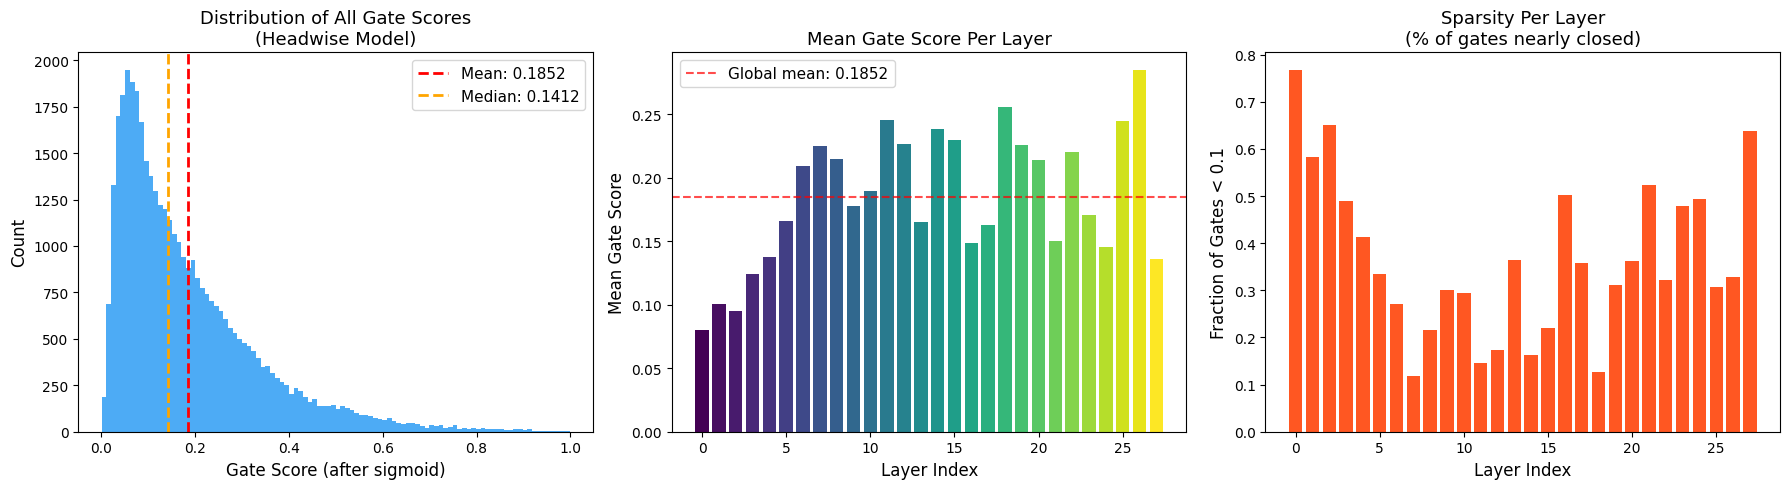


--- Summary Statistics ---
Global mean gate score:   0.1852
Global median gate score: 0.1412
Global std:               0.1522
Fraction near 0 (<0.1):   36.64%
Fraction near 1 (>0.9):   0.15%
Fraction 'mid-range' (0.1-0.9): 63.21%


In [8]:
# Collect all gate scores across all prompts and layers into one big array
all_scores_flat = []
per_layer_means = []

num_layers = len(all_results_hw[list(prompts.keys())[0]])

for layer_idx in range(num_layers):
    layer_scores = []
    for name in prompts:
        scores = all_results_hw[name][layer_idx]  # [1, seq_len, num_heads, gate_dim]
        layer_scores.append(scores.squeeze(0).numpy())  # [seq_len, num_heads, gate_dim]
    layer_all = np.concatenate([s.flatten() for s in layer_scores])
    all_scores_flat.append(layer_all)
    per_layer_means.append(layer_all.mean())

global_all = np.concatenate(all_scores_flat)

# --- Plot 1: Global distribution ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram of all gate scores
ax = axes[0]
ax.hist(global_all, bins=100, color='#2196F3', edgecolor='none', alpha=0.8)
ax.axvline(x=global_all.mean(), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {global_all.mean():.4f}')
ax.axvline(x=np.median(global_all), color='orange', linestyle='--', linewidth=2,
           label=f'Median: {np.median(global_all):.4f}')
ax.set_xlabel('Gate Score (after sigmoid)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of All Gate Scores\n(Headwise Model)', fontsize=13)
ax.legend(fontsize=11)

# Per-layer mean gate score
ax = axes[1]
colors = plt.cm.viridis(np.linspace(0, 1, num_layers))
ax.bar(range(num_layers), per_layer_means, color=colors)
ax.axhline(y=global_all.mean(), color='red', linestyle='--', alpha=0.7, label=f'Global mean: {global_all.mean():.4f}')
ax.set_xlabel('Layer Index', fontsize=12)
ax.set_ylabel('Mean Gate Score', fontsize=12)
ax.set_title('Mean Gate Score Per Layer', fontsize=13)
ax.legend(fontsize=11)

# Per-layer sparsity (fraction of gates < 0.1)
ax = axes[2]
sparsity_per_layer = [np.mean(scores < 0.1) for scores in all_scores_flat]
ax.bar(range(num_layers), sparsity_per_layer, color='#FF5722')
ax.set_xlabel('Layer Index', fontsize=12)
ax.set_ylabel('Fraction of Gates < 0.1', fontsize=12)
ax.set_title('Sparsity Per Layer\n(% of gates nearly closed)', fontsize=13)

plt.tight_layout()
plt.savefig('headwise_gate_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n--- Summary Statistics ---")
print(f"Global mean gate score:   {global_all.mean():.4f}")
print(f"Global median gate score: {np.median(global_all):.4f}")
print(f"Global std:               {global_all.std():.4f}")
print(f"Fraction near 0 (<0.1):   {np.mean(global_all < 0.1):.2%}")
print(f"Fraction near 1 (>0.9):   {np.mean(global_all > 0.9):.2%}")
print(f"Fraction 'mid-range' (0.1-0.9): {np.mean((global_all >= 0.1) & (global_all <= 0.9)):.2%}")

## Step 6: Analysis 2 — Per-Head Gate Scores (Which Heads Are On/Off?)

In headwise gating, each attention head gets a single scalar gate.
Some heads might be consistently shut off — effectively "pruned" by the gate.
Others might always be on. Let's find out.

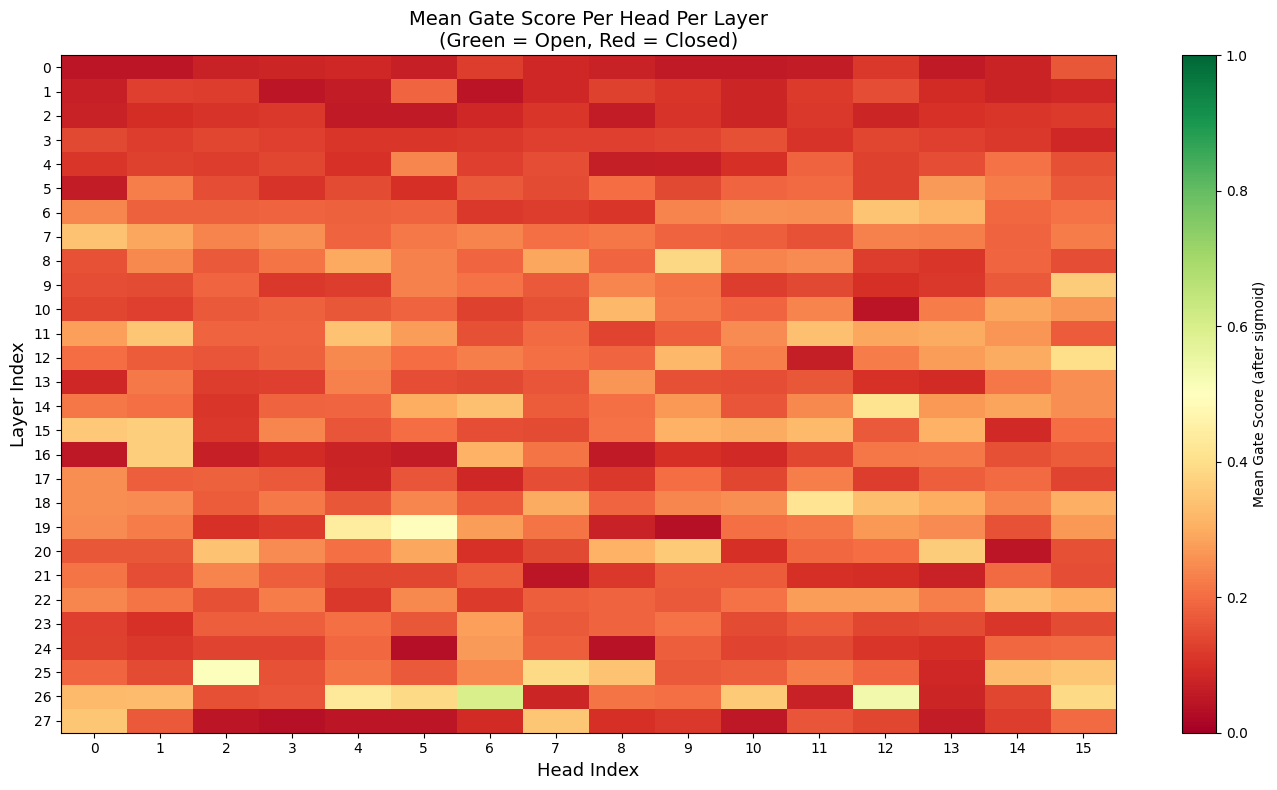


--- Heads ranked by average gate openness (across all layers) ---
Most CLOSED heads (lowest gate scores):
  Head 3: mean gate = 0.1572
  Head 2: mean gate = 0.1659
  Head 8: mean gate = 0.1668
  Head 10: mean gate = 0.1702
  Head 7: mean gate = 0.1767
Most OPEN heads (highest gate scores):
  Head 11: mean gate = 0.1896
  Head 5: mean gate = 0.1929
  Head 12: mean gate = 0.1935
  Head 1: mean gate = 0.1955
  Head 15: mean gate = 0.2152

--- Layers ranked by average gate openness ---
Most CLOSED layers:
  Layer 0: mean gate = 0.0794
  Layer 2: mean gate = 0.0924
  Layer 1: mean gate = 0.0995
  Layer 3: mean gate = 0.1241
  Layer 27: mean gate = 0.1308
Most OPEN layers:
  Layer 14: mean gate = 0.2380
  Layer 25: mean gate = 0.2424
  Layer 11: mean gate = 0.2438
  Layer 18: mean gate = 0.2534
  Layer 26: mean gate = 0.2787


In [9]:
# Build a matrix: [num_layers, num_heads] = mean gate score
# Average across all prompts and all tokens

num_heads = model_hw.config.num_attention_heads
head_gate_matrix = np.zeros((num_layers, num_heads))

for layer_idx in range(num_layers):
    head_scores = []
    for name in prompts:
        scores = all_results_hw[name][layer_idx]  # [1, seq_len, num_heads, 1]
        # Average across batch and seq_len, keep per-head
        per_head = scores.squeeze(0).squeeze(-1).mean(dim=0).numpy()  # [num_heads]
        head_scores.append(per_head)
    head_gate_matrix[layer_idx] = np.mean(head_scores, axis=0)

# --- Heatmap: Layer x Head ---
fig, ax = plt.subplots(figsize=(14, 8))
im = ax.imshow(head_gate_matrix, aspect='auto', cmap='RdYlGn', vmin=0, vmax=1)
ax.set_xlabel('Head Index', fontsize=13)
ax.set_ylabel('Layer Index', fontsize=13)
ax.set_title('Mean Gate Score Per Head Per Layer\n(Green = Open, Red = Closed)', fontsize=14)
ax.set_xticks(range(0, num_heads, max(1, num_heads//16)))
ax.set_yticks(range(0, num_layers, max(1, num_layers//16)))
cbar = plt.colorbar(im, ax=ax, label='Mean Gate Score (after sigmoid)')
plt.tight_layout()
plt.savefig('headwise_per_head_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# Find consistently dead and alive heads
head_means_global = head_gate_matrix.mean(axis=0)  # avg across layers
layer_means_global = head_gate_matrix.mean(axis=1)  # avg across heads

print("\n--- Heads ranked by average gate openness (across all layers) ---")
sorted_heads = np.argsort(head_means_global)
print("Most CLOSED heads (lowest gate scores):")
for h in sorted_heads[:5]:
    print(f"  Head {h}: mean gate = {head_means_global[h]:.4f}")
print("Most OPEN heads (highest gate scores):")
for h in sorted_heads[-5:]:
    print(f"  Head {h}: mean gate = {head_means_global[h]:.4f}")

print(f"\n--- Layers ranked by average gate openness ---")
sorted_layers = np.argsort(layer_means_global)
print("Most CLOSED layers:")
for l in sorted_layers[:5]:
    print(f"  Layer {l}: mean gate = {layer_means_global[l]:.4f}")
print("Most OPEN layers:")
for l in sorted_layers[-5:]:
    print(f"  Layer {l}: mean gate = {layer_means_global[l]:.4f}")

## Step 7: Analysis 3 — Token-Level Gate Patterns

Do certain types of tokens get gated differently?
The paper found that gating eliminates the attention sink (disproportionate attention on token 0).
Let's check: does the first token have different gate scores than other tokens?

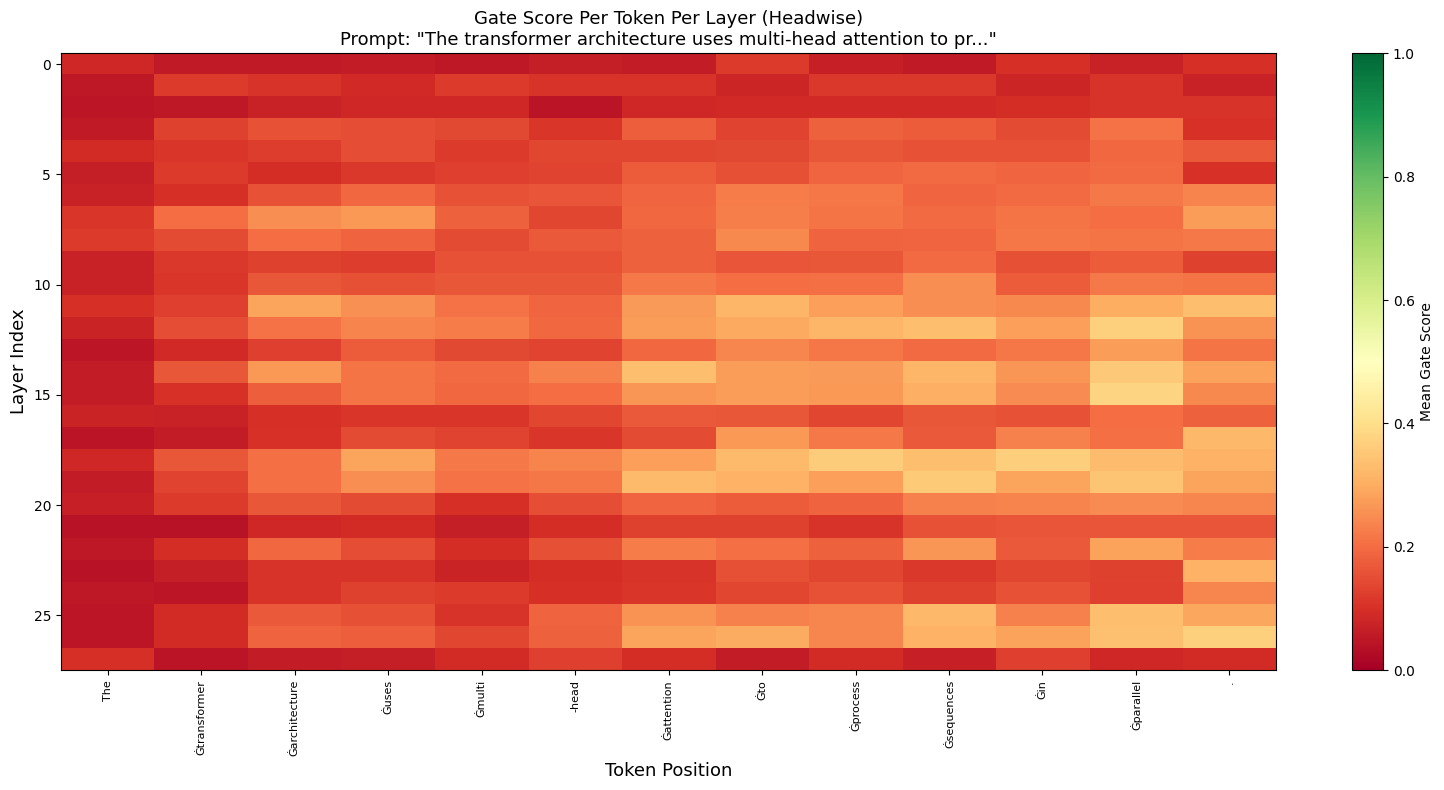

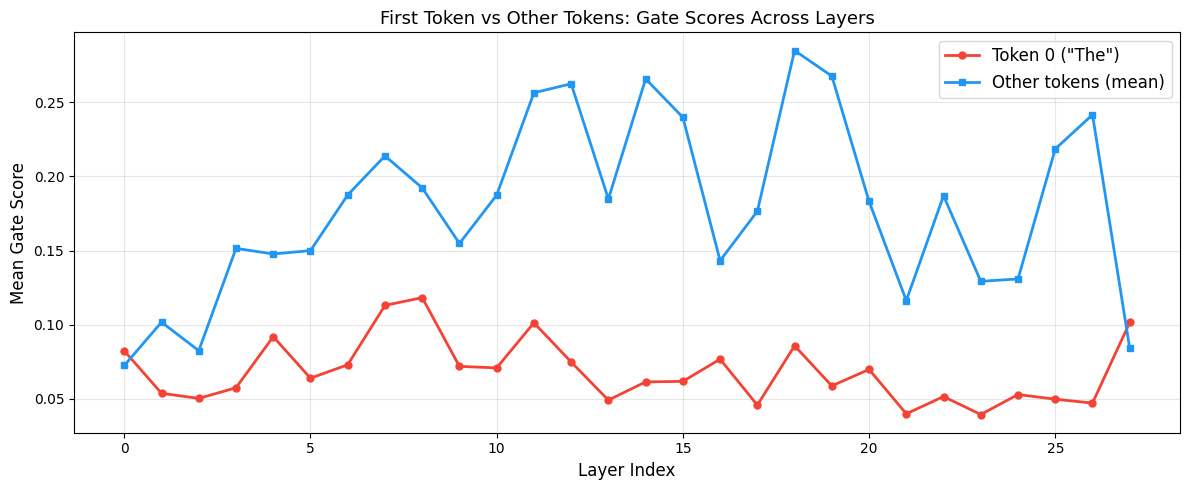

First token mean gate (all layers): 0.0684
Other tokens mean gate (all layers): 0.1790
Difference: 0.1106


In [10]:
# Use the technical prompt for this analysis
prompt_name = "technical"
tokens = all_tokens_hw[prompt_name]
gate_scores = all_results_hw[prompt_name]

# Build matrix: [num_layers, seq_len] = mean gate score across heads
seq_len = len(tokens)
token_gate_matrix = np.zeros((num_layers, seq_len))

for layer_idx in range(num_layers):
    scores = gate_scores[layer_idx]  # [1, seq_len, num_heads, 1]
    per_token = scores.squeeze(0).squeeze(-1).mean(dim=-1).numpy()  # [seq_len] mean across heads
    token_gate_matrix[layer_idx] = per_token

# --- Heatmap: Layer x Token ---
fig, ax = plt.subplots(figsize=(16, 8))
im = ax.imshow(token_gate_matrix, aspect='auto', cmap='RdYlGn', vmin=0, vmax=1)
ax.set_xlabel('Token Position', fontsize=13)
ax.set_ylabel('Layer Index', fontsize=13)
ax.set_title(f'Gate Score Per Token Per Layer (Headwise)\nPrompt: "{prompts[prompt_name][:60]}..."', fontsize=13)
ax.set_xticks(range(seq_len))
ax.set_xticklabels(tokens, rotation=90, fontsize=8)
cbar = plt.colorbar(im, ax=ax, label='Mean Gate Score')
plt.tight_layout()
plt.savefig('headwise_token_gate_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# Compare first token vs rest
first_token_gates = token_gate_matrix[:, 0]  # [num_layers]
other_token_gates = token_gate_matrix[:, 1:].mean(axis=1)  # [num_layers]

fig, ax = plt.subplots(figsize=(12, 5))
x = range(num_layers)
ax.plot(x, first_token_gates, 'o-', color='#F44336', label=f'Token 0 ("{tokens[0]}")', linewidth=2, markersize=5)
ax.plot(x, other_token_gates, 's-', color='#2196F3', label='Other tokens (mean)', linewidth=2, markersize=5)
ax.set_xlabel('Layer Index', fontsize=12)
ax.set_ylabel('Mean Gate Score', fontsize=12)
ax.set_title('First Token vs Other Tokens: Gate Scores Across Layers', fontsize=13)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('headwise_first_token_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"First token mean gate (all layers): {first_token_gates.mean():.4f}")
print(f"Other tokens mean gate (all layers): {other_token_gates.mean():.4f}")
print(f"Difference: {other_token_gates.mean() - first_token_gates.mean():.4f}")

## Step 8: Analysis 4 — Gate Scores Across Different Input Types

Does the gate behave differently for code vs conversation vs facts vs repetition?

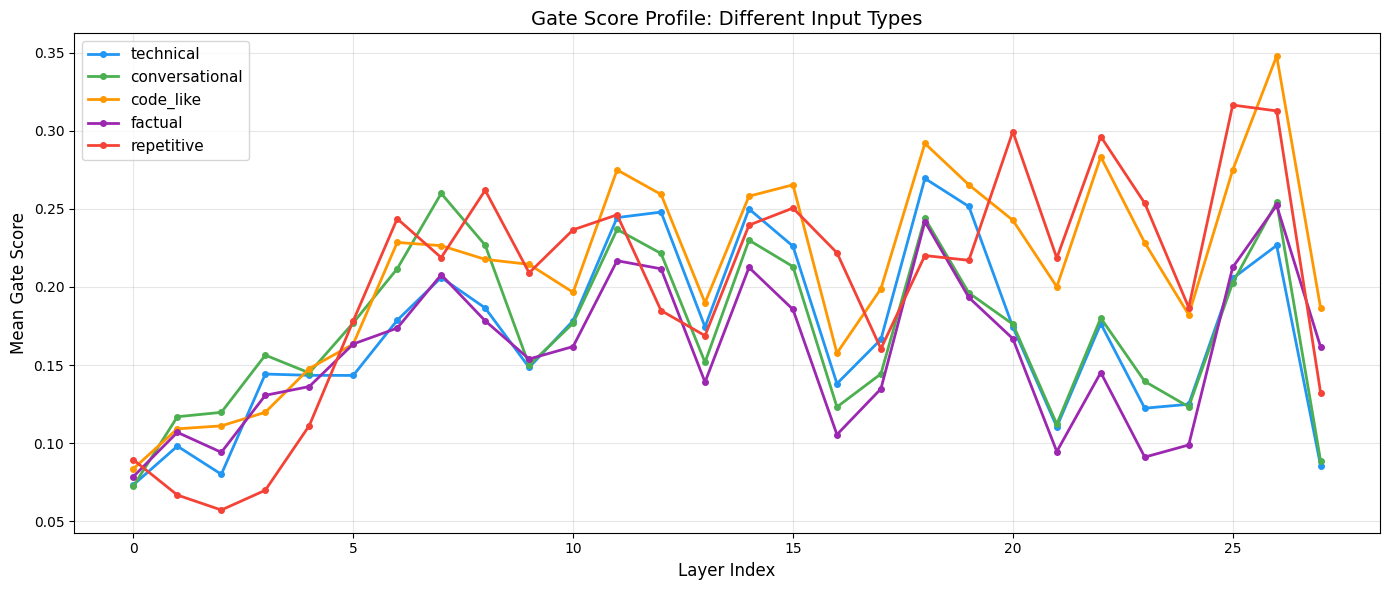


--- Per-Prompt Global Mean Gate Scores ---
  technical      : mean=0.1705, std=0.1465, <0.1: 42.2%, >0.9: 0.1%
  conversational : mean=0.1732, std=0.1396, <0.1: 39.0%, >0.9: 0.0%
  code_like      : mean=0.2116, std=0.1595, <0.1: 27.7%, >0.9: 0.2%
  factual        : mean=0.1589, std=0.1398, <0.1: 44.3%, >0.9: 0.3%
  repetitive     : mean=0.2024, std=0.1648, <0.1: 33.8%, >0.9: 0.2%


In [11]:
# Compare mean gate score per layer across different prompt types
fig, ax = plt.subplots(figsize=(14, 6))

colors_map = {
    'technical': '#2196F3',
    'conversational': '#4CAF50',
    'code_like': '#FF9800',
    'factual': '#9C27B0',
    'repetitive': '#F44336',
}

for name in prompts:
    layer_means = []
    for layer_idx in range(num_layers):
        scores = all_results_hw[name][layer_idx].numpy()
        layer_means.append(scores.mean())
    ax.plot(range(num_layers), layer_means, 'o-',
            color=colors_map[name], label=name, linewidth=2, markersize=4)

ax.set_xlabel('Layer Index', fontsize=12)
ax.set_ylabel('Mean Gate Score', fontsize=12)
ax.set_title('Gate Score Profile: Different Input Types', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('headwise_cross_prompt_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Print per-prompt summary
print("\n--- Per-Prompt Global Mean Gate Scores ---")
for name in prompts:
    all_vals = np.concatenate([all_results_hw[name][l].numpy().flatten() for l in range(num_layers)])
    print(f"  {name:15s}: mean={all_vals.mean():.4f}, std={all_vals.std():.4f}, "
          f"<0.1: {np.mean(all_vals < 0.1):.1%}, >0.9: {np.mean(all_vals > 0.9):.1%}")

## Step 9: Analysis 5 — Gate Score Variance (Are Gates Decisive or Uncertain?)

If most gate scores are near 0 or near 1 (bimodal), the gate is making clear on/off decisions.
If they're clustered around 0.5, the gate is uncertain.
The paper says they're mostly near 0 — let's verify and measure per-layer.

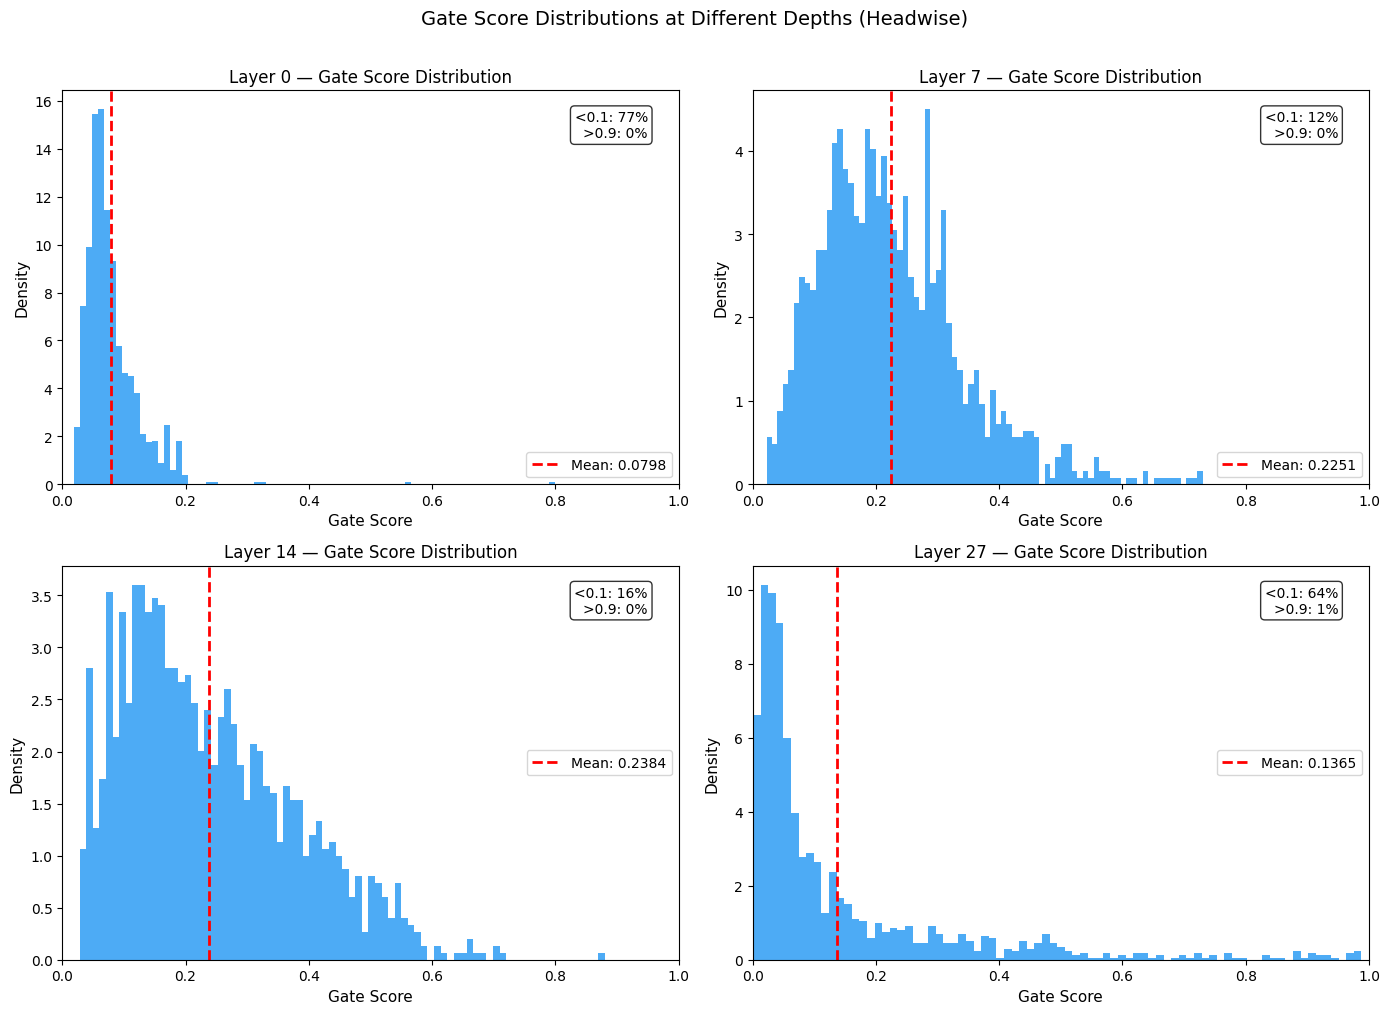

In [12]:
# Per-layer histograms for selected layers
layers_to_show = [0, num_layers//4, num_layers//2, num_layers-1]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, layer_idx in enumerate(layers_to_show):
    ax = axes[idx]
    scores = all_scores_flat[layer_idx]

    ax.hist(scores, bins=80, color='#2196F3', edgecolor='none', alpha=0.8, density=True)
    ax.axvline(x=scores.mean(), color='red', linestyle='--', linewidth=2,
               label=f'Mean: {scores.mean():.4f}')
    ax.set_xlabel('Gate Score', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'Layer {layer_idx} — Gate Score Distribution', fontsize=12)
    ax.legend(fontsize=10)
    ax.set_xlim(0, 1)

    # Add text stats
    stats_text = f'<0.1: {np.mean(scores < 0.1):.0%}\n>0.9: {np.mean(scores > 0.9):.0%}'
    ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Gate Score Distributions at Different Depths (Headwise)', fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig('headwise_per_layer_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## Step 10: Load and Analyze Elementwise Model

Now let's do the same for the elementwise model and compare.
Elementwise gives each dimension within each head its own gate — much finer-grained control.

In [13]:
# Clean up headwise model to free VRAM
extractor_hw.cleanup()
del model_hw
torch.cuda.empty_cache()

# Load elementwise model
model_ew, tokenizer_ew = load_model("gate_elementwise")
extractor_ew = GateScoreExtractor(model_ew)

# Extract gate scores on same prompts
all_results_ew = {}
all_tokens_ew = {}

for name, prompt in prompts.items():
    inputs = tokenizer_ew(prompt, return_tensors="pt").to(device)
    tokens = tokenizer_ew.convert_ids_to_tokens(inputs["input_ids"][0])

    gate_scores = extractor_ew.extract(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"]
    )

    all_results_ew[name] = gate_scores
    all_tokens_ew[name] = tokens

# Print shape difference
sample = all_results_ew[list(prompts.keys())[0]][0]
print(f"\nElementwise gate score shape: {sample.shape}")
print(f"  batch={sample.shape[0]}, seq_len={sample.shape[1]}, "
      f"num_heads={sample.shape[2]}, head_dim={sample.shape[3]}")
print(f"\nThis means each of the {sample.shape[2]} heads has {sample.shape[3]} individual gate values")
print(f"vs headwise where each head had just 1 gate value.")

Hooks removed.
Loading gate_elementwise from /content/gated_attention/1B_gate_elementwise...


You are using a model of type qwen2 to instantiate a model of type qwen3. This is not supported for all configurations of models and can yield errors.


  headwise_attn_output_gate: False
  elementwise_attn_output_gate: True
  num_attention_heads: 16
  num_key_value_heads: 8
  head_dim: 128
  num_hidden_layers: 28
  Loaded successfully!

Registered hooks on 28 layers

Elementwise gate score shape: torch.Size([1, 13, 16, 128])
  batch=1, seq_len=13, num_heads=16, head_dim=128

This means each of the 16 heads has 128 individual gate values
vs headwise where each head had just 1 gate value.


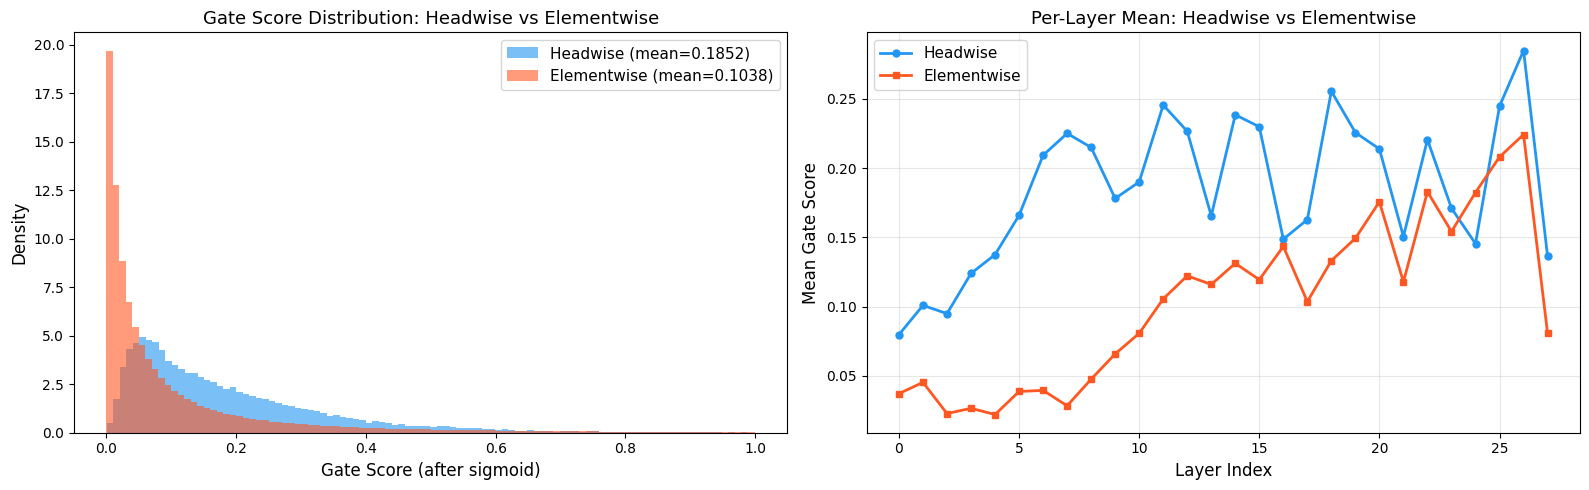


--- Comparison ---
Metric                             Headwise  Elementwise
Mean gate score                      0.1852       0.1038
Median gate score                    0.1412       0.0434
Std                                  0.1522       0.1529
Fraction < 0.1                       36.64%       70.35%
Fraction > 0.9                        0.15%        0.32%


In [14]:
# Compare elementwise vs headwise global distributions

# Collect elementwise scores
ew_all_scores_flat = []
ew_per_layer_means = []

for layer_idx in range(num_layers):
    layer_scores = []
    for name in prompts:
        scores = all_results_ew[name][layer_idx]
        layer_scores.append(scores.squeeze(0).numpy())
    layer_all = np.concatenate([s.flatten() for s in layer_scores])
    ew_all_scores_flat.append(layer_all)
    ew_per_layer_means.append(layer_all.mean())

ew_global_all = np.concatenate(ew_all_scores_flat)

# Side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Distribution comparison
ax = axes[0]
ax.hist(global_all, bins=100, alpha=0.6, color='#2196F3', label=f'Headwise (mean={global_all.mean():.4f})', density=True)
ax.hist(ew_global_all, bins=100, alpha=0.6, color='#FF5722', label=f'Elementwise (mean={ew_global_all.mean():.4f})', density=True)
ax.set_xlabel('Gate Score (after sigmoid)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Gate Score Distribution: Headwise vs Elementwise', fontsize=13)
ax.legend(fontsize=11)

# Per-layer mean comparison
ax = axes[1]
ax.plot(range(num_layers), per_layer_means, 'o-', color='#2196F3', label='Headwise', linewidth=2, markersize=5)
ax.plot(range(num_layers), ew_per_layer_means, 's-', color='#FF5722', label='Elementwise', linewidth=2, markersize=5)
ax.set_xlabel('Layer Index', fontsize=12)
ax.set_ylabel('Mean Gate Score', fontsize=12)
ax.set_title('Per-Layer Mean: Headwise vs Elementwise', fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('headwise_vs_elementwise_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n--- Comparison ---")
print(f"{'Metric':<30s} {'Headwise':>12s} {'Elementwise':>12s}")
print(f"{'='*54}")
print(f"{'Mean gate score':<30s} {global_all.mean():>12.4f} {ew_global_all.mean():>12.4f}")
print(f"{'Median gate score':<30s} {np.median(global_all):>12.4f} {np.median(ew_global_all):>12.4f}")
print(f"{'Std':<30s} {global_all.std():>12.4f} {ew_global_all.std():>12.4f}")
print(f"{'Fraction < 0.1':<30s} {np.mean(global_all < 0.1):>12.2%} {np.mean(ew_global_all < 0.1):>12.2%}")
print(f"{'Fraction > 0.9':<30s} {np.mean(global_all > 0.9):>12.2%} {np.mean(ew_global_all > 0.9):>12.2%}")

## Step 11: Analysis 6 — Within-Head Dimension Patterns (Elementwise Only)

For the elementwise model, each of the 128 dimensions within a head has its own gate.
Are certain dimensions consistently gated? Or is it random per token?

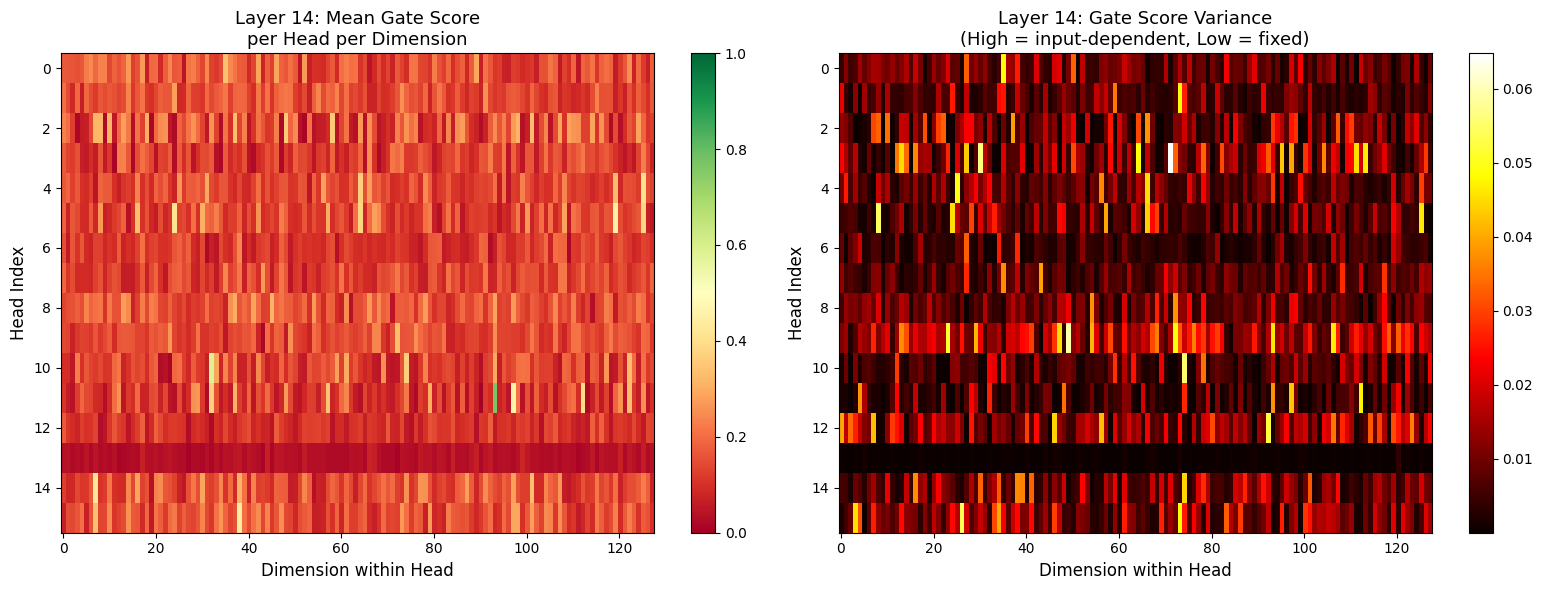


--- Layer 14 Elementwise Gate Analysis ---
Dimensions consistently closed (mean < 0.1): 31.8%
Dimensions consistently open (mean > 0.9):   0.0%
Dimensions that are input-dependent (var > 0.01): 37.4%


In [15]:
# For elementwise: look at which dimensions within a head are gated
# Pick one layer and one prompt
layer_to_inspect = num_layers // 2  # Middle layer
prompt_name = "technical"

scores = all_results_ew[prompt_name][layer_to_inspect]  # [1, seq_len, num_heads, head_dim]
scores = scores.squeeze(0).numpy()  # [seq_len, num_heads, head_dim]

# Average across tokens to see per-head, per-dimension patterns
mean_over_tokens = scores.mean(axis=0)  # [num_heads, head_dim]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap: head x dimension
ax = axes[0]
im = ax.imshow(mean_over_tokens, aspect='auto', cmap='RdYlGn', vmin=0, vmax=1)
ax.set_xlabel('Dimension within Head', fontsize=12)
ax.set_ylabel('Head Index', fontsize=12)
ax.set_title(f'Layer {layer_to_inspect}: Mean Gate Score\nper Head per Dimension', fontsize=13)
plt.colorbar(im, ax=ax)

# Variance across tokens for each dimension (is the gate consistent or input-dependent?)
var_over_tokens = scores.var(axis=0)  # [num_heads, head_dim]

ax = axes[1]
im = ax.imshow(var_over_tokens, aspect='auto', cmap='hot')
ax.set_xlabel('Dimension within Head', fontsize=12)
ax.set_ylabel('Head Index', fontsize=12)
ax.set_title(f'Layer {layer_to_inspect}: Gate Score Variance\n(High = input-dependent, Low = fixed)', fontsize=13)
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.savefig('elementwise_dimension_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# How many dimensions are "always closed" vs "always open" vs "dynamic"?
always_closed = np.mean(mean_over_tokens < 0.1)  # mean < 0.1 = consistently near 0
always_open = np.mean(mean_over_tokens > 0.9)    # mean > 0.9 = consistently near 1
dynamic = np.mean(var_over_tokens > 0.01)         # significant variance = input-dependent

print(f"\n--- Layer {layer_to_inspect} Elementwise Gate Analysis ---")
print(f"Dimensions consistently closed (mean < 0.1): {always_closed:.1%}")
print(f"Dimensions consistently open (mean > 0.9):   {always_open:.1%}")
print(f"Dimensions that are input-dependent (var > 0.01): {dynamic:.1%}")

## Step 12: Cleanup

In [16]:
extractor_ew.cleanup()
del model_ew
torch.cuda.empty_cache()
print("All cleaned up!")

Hooks removed.
All cleaned up!


## Summary: What to Look For in Your Results

**1. Distribution shape:** The paper reports mean ~0.116 for elementwise. If you see similar numbers, the pretrained models confirm heavy sparsity — most gate values near 0.

**2. Layer patterns:** Do early layers gate more aggressively than late layers? The paper found attention sink starts around layer 6. You might see a shift in gating behavior around there.

**3. Head patterns:** Are some heads always closed? If so, these are candidates for **head pruning** — you could remove them entirely for inference speedup without quality loss.

**4. First token:** If the first token gets unusually low gate scores, that's the gate "fixing" the attention sink — suppressing the irrelevant attention mass that standard models dump on token 0.

**5. Input-dependent behavior:** If gate scores change significantly across different prompt types (code vs prose vs repetition), the gate is doing content-aware filtering. If they're mostly static regardless of input, the gate has learned fixed structural patterns.

**6. Elementwise dimension patterns:** If certain dimensions within a head are consistently gated off, this suggests structured sparsity that could be exploited for efficiency.

---

## Next Steps for Experimentation

Based on what you find:
- **If heads are consistently dead:** Try head pruning at inference time (force those heads' full output to zero) and measure perplexity change.
- **If gates are mostly static (low variance):** The gate may be approximable by a fixed mask, which would eliminate the gate computation entirely at inference.
- **If certain layers don't need gating:** You could save compute by only gating specific layers.
- **If first token behaves very differently:** Try feeding different BOS tokens or removing it to see how robust the gating is.